# SCPI back

### neural net

In [7]:
import sys
import os
import time
import datetime
import numpy as np
import pandas as pd
import redpitaya_scpi as scpi
import logging
import raw_data_processing as proc  # Import your existing processing functions
from tensorflow.keras.models import load_model
import joblib
import requests

# ---------------------------
# Logging Configuration
# ---------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_acquisition.log"),
        logging.StreamHandler()
    ]
)

def load_config(config_file):
    """
    Load configuration from a JSON file.
    """
    import json
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    mlb = joblib.load(mlb_path)
    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb):
    """
    Predict the connected devices from extracted features using the trained model.
    """
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions = model.predict(scaled_features)  # Predictions as probabilities
    # Return the probabilities as a dictionary
    prob = predictions[0]
    result = {
        "timestamp": datetime.datetime.now().isoformat(),
        "empty": round(prob[0], 2),
        "ipad_on": round(prob[1], 2),
        "lamp": round(prob[2], 2),
        "mac_luca_on": round(prob[3], 2)
    }
    return result

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    """
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'

    # Map devices
    devices = [
        {'deviceId': 'device1', 'on': bool(live_results_row['mac_luca_on'] > 0.5)},
        {'deviceId': 'device2', 'on': bool(live_results_row['lamp'] > 0.5)},
        {'deviceId': 'device3', 'on': bool(live_results_row['ipad_on'] > 0.5)}
    ]

    # Prepare the request payload
    payload = {
        'devices': devices
    }

    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()
        logging.info(f"Data sent to API: {payload}")
    except requests.exceptions.HTTPError as errh:
        logging.error(f"HTTP Error: {errh}")
    except requests.exceptions.ConnectionError as errc:
        logging.error(f"Error Connecting: {errc}")
    except requests.exceptions.Timeout as errt:
        logging.error(f"Timeout Error: {errt}")
    except requests.exceptions.RequestException as err:
        logging.error(f"Request Exception: {err}")

def append_to_csv(data, csv_path):
    """
    Append new data to the CSV file. Create the file if it doesn't exist.
    """
    df = pd.DataFrame([data])  # Wrap data in a list to create a DataFrame
    file_exists = os.path.isfile(csv_path)

    if not file_exists:
        df.to_csv(csv_path, index=False)  # Create a new file with headers
        logging.info(f"Created new CSV file: {csv_path}")
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)  # Append to existing file
        logging.info(f"Appended data to CSV file: {csv_path}")

def data_acquisition(config):
    """
    Main data acquisition function.
    """
    # Extract configurations
    IP = config['ip_address']
    decimation_factor = config['decimation_factor']
    base_dir = config.get('base_dir', '.')
    session_delay = config['session_delay_seconds']

    # Load prediction resources
    model_path = "model_w1_express.h5"
    scaler_path = "scaler_w1_express.pkl"
    mlb_path = "mlb_w1_express.pkl"
    model, scaler, mlb = load_prediction_resources(model_path, scaler_path, mlb_path)

    # Path to the CSV file
    live_results_csv = os.path.join("live_results.csv")

    # Initialize Red Pitaya connection
    try:
        rp_s = scpi.scpi(IP)
        logging.info(f"Connected to Red Pitaya at {IP}")
    except Exception as e:
        logging.error(f"Failed to connect to Red Pitaya at {IP}: {e}")
        sys.exit(1)

    try:
        while True:
            logging.info("Starting data acquisition cycle.")

            # Configure Red Pitaya for acquisition
            try:
                rp_s.tx_txt('ACQ:RST')  # Reset acquisition
                rp_s.tx_txt(f'ACQ:DEC {decimation_factor}')  # Set decimation factor
                rp_s.tx_txt('ACQ:TRIG:LEV 0')  # Set trigger level
                rp_s.tx_txt('ACQ:TRIG:DLY 0')  # Set trigger delay to 0
                rp_s.tx_txt('ACQ:SOUR1:GAIN LV')  # Set input gain to Low Voltage (LV)
                rp_s.tx_txt('ACQ:START')  # Start acquisition
                logging.info("Red Pitaya configured successfully.")
            except Exception as e:
                logging.error(f"Error configuring Red Pitaya: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Trigger acquisition
            try:
                rp_s.tx_txt('ACQ:TRIG CH1_PE')  # Set trigger to CH1 positive edge
                # Wait for trigger to occur
                timeout = 5  # Timeout in seconds
                start_time = time.time()
                while True:
                    rp_s.tx_txt('ACQ:TRIG:STAT?')
                    trig_stat = rp_s.rx_txt()
                    if trig_stat.strip() == 'TD':
                        break
                    elif time.time() - start_time > timeout:
                        logging.warning("Trigger timeout. Retrying.")
                        break  # Exit the trigger wait loop
                logging.info("Trigger detected. Reading data.")
            except Exception as e:
                logging.error(f"Error triggering acquisition: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Capture data from CH1
            try:
                rp_s.tx_txt('ACQ:SOUR1:DATA?')
                raw_data_str = rp_s.rx_txt().strip('{}\n\r').split(',')
                signal = np.array([float(x) for x in raw_data_str])

                if signal.size > 0:
                    logging.info(f"Data acquired from CH1: {signal.size} samples")
                else:
                    logging.warning("No data captured from CH1")
                    time.sleep(session_delay)
                    continue  # Skip to next iteration
            except Exception as e:
                logging.error(f"Error acquiring data from CH1: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Process data using process_channel
            try:
                # Process the signal using the process_channel function
                channel_label = 'ch1'
                processing_method = 'welch'

                # Decimation factor is already given
                features = proc.process_channel(signal, channel_label, decimation_factor, processing_method)

                if features is not None and len(features) > 0:
                    # Convert features to DataFrame
                    features_df = pd.DataFrame([features])

                    # Ensure that the features match the model's expected input
                    # Replace with your model's expected feature names
                    expected_feature_columns = [
                        'ch1_entropy_welch',
                        'ch1_skewness_welch',
                        'ch1_interquartile_range_welch',
                        'ch1_kurtosis_welch',
                        'ch1_percentile_75_welch',
                        'ch1_range_welch',
                        'ch1_maximum_welch',
                        'ch1_median_welch',
                        'ch1_percentile_90_welch',
                        'ch1_mean_absolute_deviation_welch'
                    ]

                    # Check if all expected features are present
                    missing_features = [col for col in expected_feature_columns if col not in features_df.columns]
                    if missing_features:
                        logging.error(f"Missing features: {missing_features}")
                        time.sleep(session_delay)
                        continue  # Skip to next iteration

                    # Reorder the DataFrame columns
                    features_df = features_df[expected_feature_columns]

                    # Perform live prediction
                    prediction_result = predict_live(
                        features_df,
                        model,
                        scaler,
                        mlb
                    )

                    # Append prediction result to CSV for testing
                    append_to_csv(prediction_result, live_results_csv)

                    # Send prediction result to API
                    send_data_to_api(prediction_result)
                    logging.info(f"Prediction result: {prediction_result}")
                else:
                    logging.warning("No features available for prediction.")
            except Exception as e:
                logging.error(f"Error processing data: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Delay before next acquisition cycle
            time.sleep(session_delay)
    except KeyboardInterrupt:
        logging.info("\nData acquisition stopped by user.")
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
    finally:
        logging.info("Data acquisition terminated.")

if __name__ == "__main__":
    try:
        config = load_config('config.json')
    except (FileNotFoundError, KeyError) as e:
        logging.error(f"Configuration Error: {e}")
        sys.exit(1)

    data_acquisition(config)

2024-12-02 12:29:57,430 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-12-02 12:29:57,563 - INFO - Connected to Red Pitaya at 192.168.8.214
2024-12-02 12:29:57,564 - INFO - Starting data acquisition cycle.
2024-12-02 12:29:57,565 - INFO - Red Pitaya configured successfully.
2024-12-02 12:29:57,670 - INFO - Trigger detected. Reading data.
2024-12-02 12:29:58,179 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-12-02 12:29:58,258 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:29:58,766 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': False}]}
2024-12-02 12:29:58,768 - INFO - Prediction result: {'timestamp': '2024-12-02T12:29:58.257133', 'empty': 0.98, 'ipad_on': 0.29, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:29:59,772 - INFO - Starting data acquisition cycle.
2024-12-02 12:29:59,775 - INFO - Red Pitaya configured successfully.
2024-12-02 12:29:59,852 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:00,764 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:00,818 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:01,228 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:01,231 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:00.817454', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:02,237 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:02,238 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:02,310 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:02,881 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:02,930 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:03,328 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:03,330 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:02.929345', 'empty': 0.04, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:04,332 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:04,333 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:04,385 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:04,772 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:04,826 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:05,387 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:05,389 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:04.825116', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:06,392 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:06,395 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:06,483 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:07,239 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:07,293 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:07,711 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:07,714 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:07.292090', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:08,719 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:08,722 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:08,789 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:09,465 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:09,515 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:09,946 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:09,948 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:09.514592', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:10,952 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:10,954 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:10,974 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:11,499 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:11,550 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:12,012 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:12,013 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:11.549537', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:13,018 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:13,020 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:13,112 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:13,474 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:13,524 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:13,929 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:13,932 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:13.523873', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:14,936 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:14,939 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:15,004 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:15,304 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:15,350 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:16,288 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:16,290 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:15.349592', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:17,295 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:17,296 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:17,330 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:17,991 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:18,047 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:18,429 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:18,432 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:18.046768', 'empty': 0.1, 'ipad_on': 0.98, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:19,436 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:19,438 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:19,638 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:19,985 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:20,038 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:20,427 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:20,429 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:20.037539', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:21,434 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:21,435 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:21,453 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:21,892 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:21,943 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:22,368 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:22,370 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:21.943101', 'empty': 0.01, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:23,372 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:23,374 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:23,463 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:23,909 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:23,960 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:24,582 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:24,584 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:23.959887', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:25,589 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:25,591 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:25,686 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:26,253 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:26,310 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:26,724 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:26,726 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:26.309094', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:27,730 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:27,732 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:27,786 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:28,283 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-12-02 12:30:28,327 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:28,817 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:28,818 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:28.326428', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:29,821 - INFO - Starting data acquisition cycle.
2024-12-02 12:30:29,823 - INFO - Red Pitaya configured successfully.
2024-12-02 12:30:29,943 - INFO - Trigger detected. Reading data.
2024-12-02 12:30:30,531 - INFO - Data acquired from CH1: 16384 samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-02 12:30:30,583 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 12:30:31,122 - INFO - Data sent to API: {'devices': [{'deviceId': 'device1', 'on': False}, {'deviceId': 'device2', 'on': False}, {'deviceId': 'device3', 'on': True}]}
2024-12-02 12:30:31,123 - INFO - Prediction result: {'timestamp': '2024-12-02T12:30:30.582441', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_luca_on': 0.0}
2024-12-02 12:30:31,927 - INFO - 
Data acquisition stopped by user.
2024-12-02 12:30:31,928 - INFO - Data acquisition terminated.


## KNN

In [4]:
import sys
import os
import time
import datetime
import numpy as np
import pandas as pd
import redpitaya_scpi as scpi
import logging
import raw_data_processing as proc  # Import your existing processing functions
from sklearn.neighbors import KNeighborsClassifier
import joblib
import requests

# ---------------------------
# Logging Configuration
# ---------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_acquisition.log"),
        logging.StreamHandler()
    ]
)

def load_config(config_file):
    """
    Load configuration from a JSON file.
    """
    import json
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def load_prediction_resources(model_path, scaler_path):
    """
    Load the trained KNN model and scaler for predictions.
    """
    # Load the KNN model and scaler using joblib
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    return model, scaler

def predict_live(features_df, model, scaler, class_labels):
    """
    Predict the connected devices from extracted features using the trained KNN model.
    """
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions_proba = model.predict_proba(scaled_features)  # Predictions as probabilities

    # Get the class probabilities for the first (and only) sample
    prob = predictions_proba[0]

    # Map probabilities to their corresponding class labels
    result = {"timestamp": datetime.datetime.now().isoformat()}
    for label, p in zip(class_labels, prob):
        result[label] = round(p, 2)
    return result

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    """
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'

    # Map devices (adjust deviceIds and class labels as needed)
    devices = [
        {'deviceId': 'device1', 'on': live_results_row.get('mac_luca_on', 0) > 0.5},
        {'deviceId': 'device2', 'on': live_results_row.get('lamp', 0) > 0.5},
        {'deviceId': 'device3', 'on': live_results_row.get('ipad_on', 0) > 0.5}
    ]

    # Prepare the request payload
    payload = {
        'devices': devices
    }

    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()
        logging.info(f"Data sent to API: {payload}")
    except requests.exceptions.HTTPError as errh:
        logging.error(f"HTTP Error: {errh}")
    except requests.exceptions.ConnectionError as errc:
        logging.error(f"Error Connecting: {errc}")
    except requests.exceptions.Timeout as errt:
        logging.error(f"Timeout Error: {errt}")
    except requests.exceptions.RequestException as err:
        logging.error(f"Request Exception: {err}")

def append_to_csv(data, csv_path):
    """
    Append new data to the CSV file. Create the file if it doesn't exist.
    """
    df = pd.DataFrame([data])  # Wrap data in a list to create a DataFrame
    file_exists = os.path.isfile(csv_path)

    if not file_exists:
        df.to_csv(csv_path, index=False)  # Create a new file with headers
        logging.info(f"Created new CSV file: {csv_path}")
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)  # Append to existing file
        logging.info(f"Appended data to CSV file: {csv_path}")

def data_acquisition(config):
    """
    Main data acquisition function.
    """
    # Extract configurations
    IP = config['ip_address']
    decimation_factor = config['decimation_factor']
    base_dir = config.get('base_dir', '.')
    session_delay = config['session_delay_seconds']

    # Load prediction resources
    model_path = "model_knn2.h5"
    scaler_path = "scaler_knn2.pkl"
    model, scaler = load_prediction_resources(model_path, scaler_path)

    # Get class labels from the model (assuming they are stored in the model)
    class_labels = model.classes_

    # Path to the CSV file
    live_results_csv = os.path.join("live_results.csv")

    # Initialize Red Pitaya connection
    try:
        rp_s = scpi.scpi(IP)
        logging.info(f"Connected to Red Pitaya at {IP}")
    except Exception as e:
        logging.error(f"Failed to connect to Red Pitaya at {IP}: {e}")
        sys.exit(1)

    try:
        while True:
            logging.info("Starting data acquisition cycle.")

            # Configure Red Pitaya for acquisition
            try:
                rp_s.tx_txt('ACQ:RST')  # Reset acquisition
                rp_s.tx_txt(f'ACQ:DEC {decimation_factor}')  # Set decimation factor
                rp_s.tx_txt('ACQ:TRIG:LEV 0')  # Set trigger level
                rp_s.tx_txt('ACQ:TRIG:DLY 0')  # Set trigger delay to 0
                rp_s.tx_txt('ACQ:SOUR1:GAIN LV')  # Set input gain to Low Voltage (LV)
                rp_s.tx_txt('ACQ:START')  # Start acquisition
                logging.info("Red Pitaya configured successfully.")
            except Exception as e:
                logging.error(f"Error configuring Red Pitaya: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Trigger acquisition
            try:
                rp_s.tx_txt('ACQ:TRIG CH1_PE')  # Set trigger to CH1 positive edge
                # Wait for trigger to occur
                timeout = 5  # Timeout in seconds
                start_time = time.time()
                while True:
                    rp_s.tx_txt('ACQ:TRIG:STAT?')
                    trig_stat = rp_s.rx_txt()
                    if trig_stat.strip() == 'TD':
                        break
                    elif time.time() - start_time > timeout:
                        logging.warning("Trigger timeout. Retrying.")
                        break  # Exit the trigger wait loop
                logging.info("Trigger detected. Reading data.")
            except Exception as e:
                logging.error(f"Error triggering acquisition: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Capture data from CH1
            try:
                rp_s.tx_txt('ACQ:SOUR1:DATA?')
                raw_data_str = rp_s.rx_txt().strip('{}\n\r').split(',')
                signal = np.array([float(x) for x in raw_data_str])

                if signal.size > 0:
                    logging.info(f"Data acquired from CH1: {signal.size} samples")
                else:
                    logging.warning("No data captured from CH1")
                    time.sleep(session_delay)
                    continue  # Skip to next iteration
            except Exception as e:
                logging.error(f"Error acquiring data from CH1: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Process data using process_channel
            try:
                # Process the signal using the process_channel function
                channel_label = 'ch1'
                processing_method = 'welch'

                # Decimation factor is already given
                features = proc.process_channel(signal, channel_label, decimation_factor, processing_method)

                if features is not None and len(features) > 0:
                    # Convert features to DataFrame
                    features_df = pd.DataFrame([features])

                    # Ensure that the features match the model's expected input
                    # Replace with your model's expected feature names
                    expected_feature_columns = [
                        'ch1_entropy_welch_welch',
                        'ch1_skewness_welch_welch',
                        'ch1_interquartile_range_welch_welch',
                        'ch1_kurtosis_welch_welch',
                        'ch1_percentile_75_welch_welch',
                        'ch1_range_welch_welch',
                        'ch1_maximum_welch_welch',
                        'ch1_median_welch_welch',
                        'ch1_percentile_90_welch_welch',
                        'ch1_mean_absolute_deviation_welch_welch'
                    ]

                    expected_feature_columns = [
                        'ch1_entropy_welch',
                        'ch1_skewness_welch',
                        'ch1_interquartile_range_welch',
                        'ch1_kurtosis_welch',
                        'ch1_percentile_75_welch',
                        'ch1_range_welch',
                        'ch1_maximum_welch',
                        'ch1_median_welch',
                        'ch1_percentile_90_welch',
                        'ch1_mean_absolute_deviation_welch'
                    ]

                    # Check if all expected features are present
                    missing_features = [col for col in expected_feature_columns if col not in features_df.columns]
                    if missing_features:
                        logging.error(f"Missing features: {missing_features}")
                        time.sleep(session_delay)
                        continue  # Skip to next iteration

                    # Reorder the DataFrame columns
                    features_df = features_df[expected_feature_columns]

                    # Perform live prediction
                    prediction_result = predict_live(
                        features_df,
                        model,
                        scaler,
                        class_labels
                    )

                    # Append prediction result to CSV for testing
                    append_to_csv(prediction_result, live_results_csv)

                    # Send prediction result to API
                    #send_data_to_api(prediction_result)
                    logging.info(f"Prediction result: {prediction_result}")
                else:
                    logging.warning("No features available for prediction.")
            except Exception as e:
                logging.error(f"Error processing data: {e}")
                time.sleep(session_delay)
                continue  # Skip to next iteration

            # Delay before next acquisition cycle
            time.sleep(session_delay)
    except KeyboardInterrupt:
        logging.info("\nData acquisition stopped by user.")
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
    finally:
        logging.info("Data acquisition terminated.")

if __name__ == "__main__":
    try:
        config = load_config('config.json')
    except (FileNotFoundError, KeyError) as e:
        logging.error(f"Configuration Error: {e}")
        sys.exit(1)

    data_acquisition(config)


2024-12-02 13:23:06,752 - INFO - Connected to Red Pitaya at 192.168.8.214
2024-12-02 13:23:06,752 - INFO - Starting data acquisition cycle.
2024-12-02 13:23:06,753 - INFO - Red Pitaya configured successfully.
2024-12-02 13:23:06,768 - INFO - Trigger detected. Reading data.
2024-12-02 13:23:07,040 - INFO - Data acquired from CH1: 16384 samples
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
2024-12-02 13:23:07,051 - INFO - Appended data to CSV file: live_results.csv
2024-12-02 13:23:07,052 - INFO - Prediction result: {'timestamp': '2024-12-02T13:23:07.050208', 'empty': 0.0, 'ipad_on': 1.0, 'lamp': 0.0, 'mac_aug_on': 0.0}
2024-12-02 13:23:07,053 - INFO - Starting data acquisition cycle.
2024-12-02 13:23:07,053 - INFO - Red Pitaya configured successfully.
2024-12-02 13:23:07,073 - INFO - Trigger detected. Reading data.
2024-12-02 13:23:07,

### luca

In [2]:
import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import logging
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
import shutil
from collections import Counter

# ---------------------------
# Logging Configuration
# ---------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("collect_live_data_and_predict.log"),
        logging.StreamHandler()
    ]
)

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    mlb = joblib.load(mlb_path)
    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb):
    """
    Predict the connected devices from extracted features using the trained model.
    """
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions = model.predict(scaled_features)
    predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
    return predicted_labels

def main():
    """
    Main function to collect live data, process it, and display live predictions.
    """
    try:
        # Load configuration
        config = adq.load_config("config.json")
        session_duration = config["session_duration_seconds"]
        session_delay = config["session_delay_seconds"]
        decimation_factor = config.get("decimation_factor", 1024)
        base_dir = config.get("base_dir", "intermediate_files")  # Save location for files

        # Ensure base directory exists
        os.makedirs(base_dir, exist_ok=True)

        # Load prediction resources
        model_path = "model_w1_mini.h5"
        scaler_path = "scaler_w1_mini.pkl"
        mlb_path = "mlb_w1_mini.pkl"
        model, scaler, mlb = load_prediction_resources(model_path, scaler_path, mlb_path)

        # Extract streaming configurations
        ip_address = config["ip_address"]
        streaming_port = config["streaming_port"]
        buffer_size = 16384

        # Connect to Red Pitaya streaming server
        logging.info(f"Connecting to Red Pitaya at {ip_address}:{streaming_port}...")
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((ip_address, streaming_port))
        logging.info("Connection successful!")

        try:
            session_index = 1
            while True:
                # Flush socket buffer before starting
                logging.info("Flushing socket buffer...")
                adq.flush_socket(sock, buffer_size, flush_time=session_delay - session_duration)

                # Stream data for the defined duration
                raw_data = b''
                logging.info(f"Streaming data for {session_duration} seconds...")
                start_time = time.time()
                while time.time() - start_time < session_duration:
                    chunk = sock.recv(buffer_size)
                    if not chunk:
                        logging.warning("No data received. Stopping streaming.")
                        break
                    raw_data += chunk

                # Save raw data to a temporary binary file
                temp_filepath = f"temp_session_{session_index:03d}.bin"
                with open(temp_filepath, "wb") as temp_file:
                    temp_file.write(raw_data)

                # Rename the temporary file to match the expected pattern
                session_filename = f"session_{session_index:03d}.bin"
                shutil.move(temp_filepath, session_filename)

                # Process raw binary data and extract features
                logging.info("Processing raw binary data...")
                session_data_list = proc.process_session(
                    binary_filepath=session_filename,
                    decimation_factor=decimation_factor,
                    batch_size=10000,
                    augment=False
                )

                if session_data_list:
                    features_df = pd.DataFrame(session_data_list)
                    features_filepath = os.path.join(base_dir, f"features_session_{session_index:03d}.csv")
                    features_df.to_csv(features_filepath, index=False)
                    logging.info(f"Full extracted features saved to {features_filepath}")

                    # Filter features for CH1 and Welch
                    filtered_features_df = features_df.filter(regex=r'^ch1_.*_welch$')
                    filtered_filepath = os.path.join(base_dir, f"filtered_features_session_{session_index:03d}.csv")
                    filtered_features_df.to_csv(filtered_filepath, index=False)
                    logging.info(f"Filtered features saved to {filtered_filepath}")

                    # Perform live prediction
                    if not filtered_features_df.empty:
                        predictions = predict_live(filtered_features_df, model, scaler, mlb)
                        print(predictions)
                        # Aggregate predictions and count occurrences
                        predictions_flat = [tuple(sorted(pred)) for pred in predictions]
                        prediction_counts = Counter(predictions_flat)

                        # Display prediction counts
                        logging.info("Predicted device combinations and their counts:")
                        for device_combo, count in prediction_counts.items():
                            print(f"{device_combo}: {count} occurrences")

                        logging.info(f"Prediction summary: {prediction_counts}")
                    else:
                        logging.warning("No features available for prediction.")
                else:
                    logging.warning("No features extracted from the session.")

                # Clean up the temporary file
                os.remove(session_filename)

                # Increment session index
                session_index += 1

                # Sleep before the next streaming session
                logging.info(f"Sleeping for {session_delay} seconds before the next session...")
                time.sleep(session_delay)

        except KeyboardInterrupt:
            logging.info("\nLive data collection stopped by user.")
        except Exception as e:
            logging.error(f"An error occurred during streaming: {e}")
        finally:
            sock.close()
            logging.info("Socket connection closed.")

    except Exception as e:
        logging.error(f"Failed to initialize live data collection: {e}")

# if __name__ == "__main__":
#     main()

In [6]:
# money
import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import logging
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
import shutil
from collections import Counter
import requests

# ---------------------------
# Logging Configuration
# ---------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("collect_live_data_and_predict.log"),
        logging.StreamHandler()
    ]
)

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    mlb = joblib.load(mlb_path)
    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb, session_index, batch_index, results_list):
    """
    Predict the connected devices from extracted features using the trained model.
    Save probabilities for each batch to a list for later storage.
    """
    #print("Class order:", mlb.classes_)
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions = model.predict(scaled_features)  # Predictions as probabilities
    #print(predictions)
    # Collect probabilities for each batch
    for i, prob in enumerate(predictions):
        results_list.append({
            "session": session_index,
            "batch": batch_index + i + 1,
            "empty": round(prob[0], 2),
            "ipad_on": round(prob[1], 2),
            "lamp": round(prob[2], 2),
            "mac_luca_on": round(prob[3], 2)
        })

def append_to_csv(data, csv_path):
    """
    Append new data to the CSV file. Create the file if it doesn't exist.
    """
    df = pd.DataFrame(data)
    if not os.path.isfile(csv_path):
        df.to_csv(csv_path, index=False)  # Create a new file with headers
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)  # Append to existing file

def aggregate_predictions_and_send(input_csv, output_csv):
    """
    Aggregate probabilities by session, count the 'batch' column, and send data to an API.
    """
    if not os.path.isfile(input_csv):
        logging.warning(f"No data to aggregate. File {input_csv} does not exist.")
        return
    
    # Read the input predictions CSV
    predictions_df = pd.read_csv(input_csv)
    
    # Group by session and aggregate data
    agg_df = predictions_df.groupby("session").agg(
        batch_count=("batch", "count"),  # Count the number of batches
        empty=("empty", "mean"),  # Sum probabilities for empty
        ipad_on=("ipad_on", "mean"),  # Sum probabilities for ipad_on
        lamp=("lamp", "mean"),  # Sum probabilities for lamp
        mac_luca_on=("mac_luca_on", "mean")  # Sum probabilities for mac_luca_on

    ).reset_index()
    
    # Round probabilities to 2 decimal places
    agg_df = agg_df.round(2)
    
    # Save aggregated data to a new CSV
    agg_df.to_csv(output_csv, index=False)
    logging.info(f"Aggregated predictions saved to {output_csv}")
    
    # Send each session's data to the API
    for _, row in agg_df.iterrows():
        send_data_to_api(row)

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    
    Parameters:
    - live_results_row: Dictionary containing device counts.
    """
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'
    
    # Map devices
    #print(live_results_row)
    devices = [
        {'deviceId': 'device1', 'on': bool(live_results_row['mac_luca_on'] > 0.0)},
        {'deviceId': 'device2', 'on': bool(live_results_row['lamp'] > 0.0)},
        {'deviceId': 'device3', 'on': bool(live_results_row['ipad_on'] > 0.0)}
    ]
    
    # Prepare the request payload
    payload = {
        'devices': devices
    }
    #print(payload)
    
    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
        #print('Status Code:', response.status_code)
        #print('Response Body:', response.json())
    except requests.exceptions.HTTPError as errh:
        #print("Http Error:", errh)
        #print('Response Body:', response.text)
        pass
    except requests.exceptions.ConnectionError as errc:
        #print("Error Connecting:", errc)
        pass
    except requests.exceptions.Timeout as errt:
        #print("Timeout Error:", errt)
        pass
    except requests.exceptions.RequestException as err:
        #print("OOps: Something Else", err)
        pass


def main():
    """
    Main function to collect live data, process it, and display live predictions.
    """
    try:
        # Load configuration
        config = adq.load_config("config.json")
        session_duration = config["session_duration_seconds"]
        session_delay = config["session_delay_seconds"]
        decimation_factor = config.get("decimation_factor", 1024)
        base_dir = config.get("base_dir", "intermediate_files")  # Save location for files

        # Ensure base directory exists
        os.makedirs(base_dir, exist_ok=True)

        # Load prediction resources
        model_path = "model_w1_solo.h5"
        scaler_path = "scaler_w1_solo.pkl"
        mlb_path = "mlb_w1_solo.pkl"
        model, scaler, mlb = load_prediction_resources(model_path, scaler_path, mlb_path)

        # Extract streaming configurations
        ip_address = config["ip_address"]
        streaming_port = config["streaming_port"]
        buffer_size = 16384

        # CSV file path to store all predictions
        all_predictions_csv = os.path.join("all_predictions.csv")
        all_predictions_agg_csv = os.path.join("all_predictions_agg.csv")

        # Connect to Red Pitaya streaming server
        logging.info(f"Connecting to Red Pitaya at {ip_address}:{streaming_port}...")
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((ip_address, streaming_port))
        logging.info("Connection successful!")

        try:
            session_index = 1
            while True:
                # Flush socket buffer before starting
                logging.info("Flushing socket buffer...")
                adq.flush_socket(sock, buffer_size, flush_time=5)

                # Stream data for the defined duration
                raw_data = b''
                logging.info(f"Streaming data for {session_duration} seconds...")
                start_time = time.time()
                while time.time() - start_time < session_duration:
                    chunk = sock.recv(buffer_size)
                    if not chunk:
                        logging.warning("No data received. Stopping streaming.")
                        break
                    raw_data += chunk

                # Save raw data to a temporary binary file
                session_filename = f"session_{session_index:03d}.bin"
                with open(session_filename, "wb") as temp_file:
                    temp_file.write(raw_data)

                # Process raw binary data and extract features
                logging.info("Processing raw binary data...")
                session_data_list = proc.process_session(
                    binary_filepath=session_filename,
                    decimation_factor=decimation_factor,
                    batch_size=10000,
                    augment=False
                )

                if session_data_list:
                    features_df = pd.DataFrame(session_data_list)

                    # Filter features for CH1 and Welch
                    filtered_features_df = features_df.filter(regex=r'^ch1_.*_welch$')

                    # Perform live prediction for each batch
                    if not filtered_features_df.empty:
                        results = []
                        for batch_index, batch in filtered_features_df.iterrows():
                            predict_live(
                                filtered_features_df.iloc[[batch_index]],
                                model,
                                scaler,
                                mlb,
                                session_index,
                                batch_index,
                                results
                            )

                        # Append the predictions to the CSV file
                        append_to_csv(results, all_predictions_csv)
                        logging.info(f"Batch predictions appended to {all_predictions_csv}")

                        # Aggregate predictions by session and save to a new CSV
                        aggregate_predictions_and_send(all_predictions_csv, all_predictions_agg_csv)
                    else:
                        logging.warning("No features available for prediction.")
                else:
                    logging.warning("No features extracted from the session.")

                # Clean up the temporary file
                os.remove(session_filename)

                # Increment session index
                session_index += 1

                # Sleep before the next streaming session
                logging.info(f"Sleeping for {session_delay} seconds before the next session...")
                time.sleep(session_delay)

        except KeyboardInterrupt:
            logging.info("\nLive data collection stopped by user.")
        except Exception as e:
            logging.error(f"An error occurred during streaming: {e}")
        finally:
            sock.close()
            logging.info("Socket connection closed.")

    except Exception as e:
        logging.error(f"Failed to initialize live data collection: {e}")

if __name__ == "__main__":
    main()


2024-12-02 11:39:50,672 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-12-02 11:39:50,676 - INFO - Connecting to Red Pitaya at 192.168.8.214:8900...
2024-12-02 11:39:50,681 - INFO - Connection successful!
2024-12-02 11:39:50,681 - INFO - Flushing socket buffer...
2024-12-02 11:39:51,595 - INFO - Streaming data for 5 seconds...
2024-12-02 11:39:56,603 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-12-02 11:39:57,256 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:39:57,260 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:40:05,427 - INFO - Sleeping for 1 seconds before the next session...
2024-12-02 11:40:06,431 - INFO - Flushing socket buffer...
2024-12-02 11:40:06,534 - INFO - Streaming data for 5 seconds...
2024-12-02 11:40:11,549 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-12-02 11:40:12,188 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:40:12,192 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:40:19,680 - INFO - Sleeping for 1 seconds before the next session...
2024-12-02 11:40:19,736 - INFO - 
Live data collection stopped by user.
2024-12-02 11:40:19,739 - INFO - Socket connection closed.


## start and stop server

In [2]:
%pip install paramiko

  Using cached paramiko-3.5.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached bcrypt-4.2.1-cp39-abi3-macosx_10_12_universal2.whl.metadata (9.8 kB)
  Using cached PyNaCl-1.5.0-cp36-abi3-macosx_10_10_universal2.whl.metadata (8.7 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached paramiko-3.5.0-py3-none-any.whl (227 kB)
Using cached bcrypt-4.2.1-cp39-abi3-macosx_10_12_universal2.whl (489 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 2.8 MB/s eta 0:00:00a 0:00:01
Using cached PyNaCl-1.5.0-cp36-abi3-macosx_10_10_universal2.whl (349 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import logging
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
from collections import deque
import requests

# ---------------------------
# Logging Configuration
# ---------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("collect_live_data_and_predict.log"),
        logging.StreamHandler()
    ]
)

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    mlb = joblib.load(mlb_path)
    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb, session_index, batch_index, results_list):
    """
    Predict the connected devices from extracted features using the trained model.
    Save probabilities for each batch to a list for later storage.
    """
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions = model.predict(scaled_features)  # Predictions as probabilities
    # Collect probabilities for each batch
    for i, prob in enumerate(predictions):
        results_list.append({
            "session": session_index,
            "batch": batch_index + i + 1,
            "empty": round(prob[0], 2),
            "ipad_on": round(prob[1], 2),
            "lamp": round(prob[2], 2),
            "mac_luca_on": round(prob[3], 2)
        })

def append_to_csv(data, csv_path):
    """
    Append new data to the CSV file. Create the file if it doesn't exist.
    """
    df = pd.DataFrame(data)
    if not os.path.isfile(csv_path):
        df.to_csv(csv_path, index=False)  # Create a new file with headers
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)  # Append to existing file

def aggregate_predictions_and_send(input_csv, output_csv):
    """
    Aggregate probabilities by session, count the 'batch' column, and send data to an API.
    """
    if not os.path.isfile(input_csv):
        logging.warning(f"No data to aggregate. File {input_csv} does not exist.")
        return
    
    # Read the input predictions CSV
    predictions_df = pd.read_csv(input_csv)
    
    # Group by session and aggregate data
    agg_df = predictions_df.groupby("session").agg(
        batch_count=("batch", "count"),  # Count the number of batches
        empty=("empty", "mean"),  # Average probabilities for empty
        ipad_on=("ipad_on", "mean"),  # Average probabilities for ipad_on
        lamp=("lamp", "mean"),  # Average probabilities for lamp
        mac_luca_on=("mac_luca_on", "mean")  # Average probabilities for mac_luca_on

    ).reset_index()
    
    # Round probabilities to 2 decimal places
    agg_df = agg_df.round(2)
    
    # Save aggregated data to a new CSV
    agg_df.to_csv(output_csv, index=False)
    logging.info(f"Aggregated predictions saved to {output_csv}")
    
    # Send each session's data to the API
    for _, row in agg_df.iterrows():
        send_data_to_api(row)

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    
    Parameters:
    - live_results_row: Dictionary containing device counts.
    """
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'
    
    # Map devices
    devices = [
        {'deviceId': 'device1', 'on': bool(live_results_row['mac_luca_on'] > 0.0)},
        {'deviceId': 'device2', 'on': bool(live_results_row['lamp'] > 0.0)},
        {'deviceId': 'device3', 'on': bool(live_results_row['ipad_on'] > 0.0)}
    ]
    
    # Prepare the request payload
    payload = {
        'devices': devices
    }
    
    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
    except requests.exceptions.HTTPError as errh:
        pass
    except requests.exceptions.ConnectionError as errc:
        pass
    except requests.exceptions.Timeout as errt:
        pass
    except requests.exceptions.RequestException as err:
        pass

def main():
    """
    Main function to collect live data, process it, and display live predictions.
    """
    try:
        # Load configuration
        config = adq.load_config("config.json")
        session_duration = config["session_duration_seconds"]
        session_delay = config["session_delay_seconds"]
        decimation_factor = config.get("decimation_factor", 1024)
        base_dir = config.get("base_dir", "intermediate_files")  # Save location for files

        # Ensure base directory exists
        os.makedirs(base_dir, exist_ok=True)

        # Load prediction resources
        model_path = "model_w1_express.h5"
        scaler_path = "scaler_w1_express.pkl"
        mlb_path = "mlb_w1_express.pkl"
        model, scaler, mlb = load_prediction_resources(model_path, scaler_path, mlb_path)

        # Extract streaming configurations
        ip_address = config["ip_address"]
        streaming_port = config["streaming_port"]
        buffer_size = 16384

        # Calculate the buffer limit
        samples_per_channel = 20000  # Number of samples per channel
        bytes_per_sample = 4  # 2 bytes per channel * 2 channels
        buffer_limit = samples_per_channel * bytes_per_sample  # Total bytes to keep

        # CSV file path to store all predictions
        all_predictions_csv = os.path.join("all_predictions.csv")
        all_predictions_agg_csv = os.path.join("all_predictions_agg.csv")

        # Connect to Red Pitaya streaming server
        logging.info(f"Connecting to Red Pitaya at {ip_address}:{streaming_port}...")
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((ip_address, streaming_port))
        logging.info("Connection successful!")

        try:
            session_index = 1
            while True:
                # Flush socket buffer before starting
                logging.info("Flushing socket buffer...")
                adq.flush_socket(sock, buffer_size, flush_time=1)  # Short flush

                # Stream data for the defined duration
                raw_data = b''
                logging.info(f"Streaming data for {session_duration} seconds...")
                start_time = time.time()
                while time.time() - start_time < session_duration:
                    chunk = sock.recv(buffer_size)
                    if not chunk:
                        logging.warning("No data received. Stopping streaming.")
                        break
                    raw_data += chunk
                    # Keep only the last buffer_limit bytes
                    if len(raw_data) > buffer_limit:
                        raw_data = raw_data[-buffer_limit:]

                # Ensure raw_data length is a multiple of 4 bytes
                remainder = len(raw_data) % bytes_per_sample
                if remainder != 0:
                    raw_data = raw_data[remainder:]

                # Save raw data to a temporary binary file
                session_filename = f"session_{session_index:03d}.bin"
                with open(session_filename, "wb") as temp_file:
                    temp_file.write(raw_data)

                # Process raw binary data and extract features
                logging.info("Processing raw binary data...")
                session_data_list = proc.process_session(
                    binary_filepath=session_filename,
                    decimation_factor=decimation_factor,
                    batch_size=10000,
                    augment=False
                )

                if session_data_list:
                    features_df = pd.DataFrame(session_data_list)

                    # Filter features for CH1 and Welch
                    filtered_features_df = features_df.filter(regex=r'^ch1_.*_welch$')

                    # Perform live prediction for each batch
                    if not filtered_features_df.empty:
                        results = []
                        for batch_index, batch in filtered_features_df.iterrows():
                            predict_live(
                                filtered_features_df.iloc[[batch_index]],
                                model,
                                scaler,
                                mlb,
                                session_index,
                                batch_index,
                                results
                            )

                        # Append the predictions to the CSV file
                        append_to_csv(results, all_predictions_csv)
                        logging.info(f"Batch predictions appended to {all_predictions_csv}")

                        # Aggregate predictions by session and save to a new CSV
                        aggregate_predictions_and_send(all_predictions_csv, all_predictions_agg_csv)
                    else:
                        logging.warning("No features available for prediction.")
                else:
                    logging.warning("No features extracted from the session.")

                # Clean up the temporary file
                os.remove(session_filename)

                # Increment session index
                session_index += 1

                # Sleep before the next streaming session
                logging.info(f"Sleeping for {session_delay} seconds before the next session...")
                time.sleep(session_delay)

        except KeyboardInterrupt:
            logging.info("\nLive data collection stopped by user.")
        except Exception as e:
            logging.error(f"An error occurred during streaming: {e}")
        finally:
            sock.close()
            logging.info("Socket connection closed.")

    except Exception as e:
        logging.error(f"Failed to initialize live data collection: {e}")

if __name__ == "__main__":
    main()


2024-12-02 11:57:19,403 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-12-02 11:57:19,406 - INFO - Connecting to Red Pitaya at 192.168.8.214:8900...
2024-12-02 11:57:19,412 - INFO - Connection successful!
2024-12-02 11:57:19,412 - INFO - Flushing socket buffer...
2024-12-02 11:57:19,514 - INFO - Streaming data for 2 seconds...
2024-12-02 11:57:21,523 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-12-02 11:57:21,619 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:57:21,623 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:57:28,986 - INFO - Sleeping for 1 seconds before the next session...
2024-12-02 11:57:29,991 - INFO - Flushing socket buffer...
2024-12-02 11:57:30,251 - INFO - Streaming data for 2 seconds...
2024-12-02 11:57:32,289 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-12-02 11:57:32,382 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:57:32,386 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:57:39,267 - INFO - Sleeping for 1 seconds before the next session...
2024-12-02 11:57:40,270 - INFO - Flushing socket buffer...
2024-12-02 11:57:41,296 - INFO - Streaming data for 2 seconds...
2024-12-02 11:57:43,313 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-12-02 11:57:43,406 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:57:43,410 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:57:50,588 - INFO - Sleeping for 1 seconds before the next session...
2024-12-02 11:57:51,594 - INFO - Flushing socket buffer...
2024-12-02 11:57:52,292 - INFO - Streaming data for 2 seconds...
2024-12-02 11:57:54,302 - INFO - Processing raw binary data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-12-02 11:57:54,393 - INFO - Batch predictions appended to all_predictions.csv
2024-12-02 11:57:54,397 - INFO - Aggregated predictions saved to all_predictions_agg.csv
2024-12-02 11:57:56,569 - INFO - 
Live data collection stopped by user.
2024-12-02 11:57:56,569 - INFO - Socket connection closed.


In [1]:
import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
import shutil
from collections import Counter
import json
import requests

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    mlb = joblib.load(mlb_path)
    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb, prediction_threshold=0.5):
    """
    Predict the connected devices from extracted features using the trained model.
    """
    # Ensure features match the model's expected input
    scaled_features = scaler.transform(features_df)
    predictions = model.predict(scaled_features)
    predicted_labels = mlb.inverse_transform((predictions > prediction_threshold).astype(int))
    return predicted_labels

def load_config():
    """
    Load and return configuration settings.
    """
    config = adq.load_config("config.json")
    session_duration = config.get("session_duration_seconds", 1)
    session_delay = config.get("session_delay_seconds", 2)
    decimation_factor = config.get("decimation_factor", 1024)
    base_dir = config.get("base_dir", "intermediate_files")  # Save location for files
    ip_address = config.get("ip_address", "127.0.0.1")
    streaming_port = config.get("streaming_port", 8000)
    buffer_size = config.get("buffer_size", 16384)
    
    return {
        "session_duration": session_duration,
        "session_delay": session_delay,
        "decimation_factor": decimation_factor,
        "base_dir": base_dir,
        "ip_address": ip_address,
        "streaming_port": streaming_port,
        "buffer_size": buffer_size
    }

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    
    Parameters:
    - live_results_row: Dictionary containing device counts.
    """
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'
    
    # Map devices
    print(live_results_row)
    devices = [
        {'deviceId': 'device1', 'on': live_results_row['mac_luca_on'] > 0.0},
        {'deviceId': 'device2', 'on': live_results_row['lamp'] > 0.0},
        {'deviceId': 'device3', 'on': live_results_row['ipad_on'] > 0.0}
    ]
    
    # Prepare the request payload
    payload = {
        'devices': devices
    }
    print(payload)
    
    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
        #print('Status Code:', response.status_code)
        #print('Response Body:', response.json())
    except requests.exceptions.HTTPError as errh:
        #print("Http Error:", errh)
        #print('Response Body:', response.text)
        pass
    except requests.exceptions.ConnectionError as errc:
        #print("Error Connecting:", errc)
        pass
    except requests.exceptions.Timeout as errt:
        #print("Timeout Error:", errt)
        pass
    except requests.exceptions.RequestException as err:
        #print("OOps: Something Else", err)
        pass

def main(
    channels,
    preprocessing,
    mlb_filename,
    scaler_filename,
    model_filename,
    session_duration,
    prediction_threshold,
    batch_size
):
    """
    Main function to collect live data, process it, and display live predictions.
    
    Parameters:
    - channels: List of channels to use (e.g., ['ch1'], ['ch2'], ['ch1', 'ch2'])
    - preprocessing: List of preprocessing methods to apply (e.g., ['welch'], ['hist'], ['welch', 'hist'])
    - mlb_filename: Filename for the MultiLabelBinarizer
    - scaler_filename: Filename for the scaler
    - model_filename: Filename for the trained model
    - session_duration: Duration of each data collection session in seconds
    - prediction_threshold: Threshold for converting probabilities to binary predictions
    - batch_size: Batch size for processing data
    """
    try:
        # Load configuration
        config = load_config()
        session_duration = session_duration  # Overridden by function parameter
        session_delay = config["session_delay"]
        decimation_factor = config["decimation_factor"]
        base_dir = config["base_dir"]

        # Ensure base directory exists
        os.makedirs(base_dir, exist_ok=True)
        live_dir = "live"
        os.makedirs(live_dir, exist_ok=True)

        # Initialize live_results.csv
        live_results_filepath = os.path.join(live_dir, "live_results.csv")
        if not os.path.exists(live_results_filepath):
            # Create the CSV with headers
            header_df = pd.DataFrame(columns=['lamp', 'mac_luca_on', 'ipad_on', 'empty', 'total_count'])
            header_df.to_csv(live_results_filepath, index=False)
            #print(f"Created {live_results_filepath} with headers.")

        # Load prediction resources
        model, scaler, mlb = load_prediction_resources(model_filename, scaler_filename, mlb_filename)

        # Extract streaming configurations
        ip_address = config["ip_address"]
        streaming_port = config["streaming_port"]
        buffer_size = config["buffer_size"]

        #print(f"Connecting to Red Pitaya at {ip_address}:{streaming_port}...")
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((ip_address, streaming_port))
        #print("Connection successful!")

        try:
            session_index = 1
            while True:
                # Flush socket buffer before starting
                #print("Flushing socket buffer...")
                adq.flush_socket(sock, buffer_size, flush_time=1)

                # Stream data for the defined duration
                raw_data = b''
                #print(f"Streaming data for {session_duration} seconds...")
                start_time = time.time()
                while time.time() - start_time < session_duration:
                    chunk = sock.recv(buffer_size)
                    # if not chunk:
                    #     #print("No data received. Stopping streaming.")
                    #     break
                    raw_data += chunk

                # Save raw data to a temporary binary file
                temp_filepath = os.path.join(live_dir, f"temp_session_{session_index:03d}.bin")
                with open(temp_filepath, "wb") as temp_file:
                    temp_file.write(raw_data)

                # Rename the temporary file to match the expected pattern
                session_filename = os.path.join(live_dir, f"session_{session_index:03d}.bin")
                shutil.move(temp_filepath, session_filename)

                # Process raw binary data and extract features
                #print("Processing raw binary data...")
                session_data_list = proc.process_session(
                    binary_filepath=session_filename,
                    decimation_factor=decimation_factor,
                    batch_size=batch_size,
                    augment=False
                )

                if session_data_list:
                    features_df = pd.DataFrame(session_data_list)

                    # Dynamically create regex pattern based on channels and preprocessing
                    regex_pattern = f"^({'|'.join(channels)})_.*_({'|'.join(preprocessing)})$"
                    
                    # Filter features based on selected channels and preprocessing methods
                    filtered_features_df = features_df.filter(regex=regex_pattern)
                    
                    if not filtered_features_df.empty:
                        #print(f"Filtered features obtained for session {session_index}.")
                        # Perform live prediction
                        predictions = predict_live(filtered_features_df, model, scaler, mlb, prediction_threshold)
                        
                        # Aggregate predictions and count occurrences per device
                        device_counter = Counter()
                        for pred in predictions:
                            if pred:
                                device_counter.update(pred)
                            else:
                                device_counter.update(['empty'])
                        
                        # Ensure all required devices are present in the counter
                        required_devices = ['lamp', 'mac_luca_on', 'ipad_on', 'empty']
                        for device in required_devices:
                            if device not in device_counter:
                                device_counter[device] = 0
                        
                        # Normalize prediction counts and round to two decimal places
                        total_predictions = len(predictions)
                        if total_predictions > 0:
                            normalized_counts = {
                                device: round(device_counter[device] / total_predictions, 2) 
                                for device in required_devices
                            }
                        else:
                            normalized_counts = {device: 0.00 for device in required_devices}
                        
                        # Display normalized prediction counts
                        #print("Predicted device proportions:")
                        for device, norm_count in normalized_counts.items():
                            print(f"{device}: {norm_count:.2%} occurrences")
                        
                        # Append the normalized counts and total_count to live_results.csv
                        row = {
                            'lamp': normalized_counts['lamp'],
                            'mac_luca_on': normalized_counts['mac_luca_on'],
                            'ipad_on': normalized_counts['ipad_on'],
                            'empty': normalized_counts['empty'],
                            'total_count': total_predictions
                        }
                        row_df = pd.DataFrame([row])
                        row_df.to_csv(live_results_filepath, mode='a', header=False, index=False)
                        print(f"Appended results to {live_results_filepath}.")

                        # Send data to API
                        send_data_to_api(row)
                    else:
                        #print("No filtered features available for prediction.")
                        pass
                else:
                    #print("No features extracted from the session.")
                    pass

                # Clean up the temporary file
                os.remove(session_filename)

                # Increment session index
                session_index += 1

                # Sleep before the next streaming session
                #print(f"Sleeping for {session_delay} seconds before the next session...")
                time.sleep(session_delay)

        except KeyboardInterrupt:
            #print("\nLive data collection stopped by user.")
            pass
        except Exception as e:
            #print(f"An error occurred during streaming: {e}")
            pass
        finally:
            # sock.close()
            print("Socket connection closed.")

    except Exception as e:
        #print(f"Failed to initialize live data collection: {e}")
        pass




In [ ]:
if __name__ == "__main__":
    # Example call to main function
    main(
        channels=['ch1','ch2'],
        preprocessing=['welch'],
        mlb_filename='mlb_demo4.pkl',
        scaler_filename='scaler_demo4.pkl',
        model_filename='model_demo4.h5',
        session_duration=3,
        prediction_threshold=0.5,
        batch_size=10000
    )

    # device1 mac, device2 lamp, device3 tablet

In [1]:
import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
import requests
from collections import Counter

def load_prediction_resources(model_path, scaler_path, mlb_path):
    """
    Load the trained model, scaler, and MultiLabelBinarizer for predictions.
    """
    print("Loading prediction resources...")
    try:
        model = load_model(model_path)
        print(f"Model loaded from {model_path}.")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        raise e

    try:
        scaler = joblib.load(scaler_path)
        print(f"Scaler loaded from {scaler_path}.")
    except Exception as e:
        print(f"Error loading scaler from {scaler_path}: {e}")
        raise e

    try:
        mlb = joblib.load(mlb_path)
        print(f"MultiLabelBinarizer loaded from {mlb_path}.")
    except Exception as e:
        print(f"Error loading MultiLabelBinarizer from {mlb_path}: {e}")
        raise e

    return model, scaler, mlb

def predict_live(features_df, model, scaler, mlb, prediction_threshold=0.5):
    """
    Predict the connected devices from extracted features using the trained model.
    """
    print("Starting live prediction...")
    try:
        scaled_features = scaler.transform(features_df)
        print("Features scaled successfully.")
    except Exception as e:
        print(f"Error during feature scaling: {e}")
        raise e

    try:
        predictions = model.predict(scaled_features)
        print(f"Model predictions completed. Shape: {predictions.shape}")
    except Exception as e:
        print(f"Error during model prediction: {e}")
        raise e

    try:
        predicted_labels = mlb.inverse_transform((predictions > prediction_threshold).astype(int))
        print(f"Predicted labels obtained. Number of predictions: {len(predicted_labels)}")
    except Exception as e:
        print(f"Error during label inversion: {e}")
        raise e

    return predicted_labels

def load_config():
    """
    Load and return configuration settings.
    """
    print("Loading configuration...")
    try:
        config = adq.load_config("config.json")
        print("Configuration loaded successfully.")
    except Exception as e:
        print(f"Error loading configuration: {e}")
        raise e

    session_duration = config.get("session_duration_seconds", 1)
    session_delay = config.get("session_delay_seconds", 2)
    decimation_factor = config.get("decimation_factor", 1024)
    base_dir = config.get("base_dir", "intermediate_files")  # Save location for files
    ip_address = config.get("ip_address", "127.0.0.1")
    streaming_port = config.get("streaming_port", 8000)
    buffer_size = config.get("buffer_size", 16384)

    print(f"Configuration Parameters:\n"
          f"Session Duration: {session_duration} seconds\n"
          f"Session Delay: {session_delay} seconds\n"
          f"Decimation Factor: {decimation_factor}\n"
          f"Base Directory: {base_dir}\n"
          f"IP Address: {ip_address}\n"
          f"Streaming Port: {streaming_port}\n"
          f"Buffer Size: {buffer_size} bytes")

    return {
        "session_duration": session_duration,
        "session_delay": session_delay,
        "decimation_factor": decimation_factor,
        "base_dir": base_dir,
        "ip_address": ip_address,
        "streaming_port": streaming_port,
        "buffer_size": buffer_size
    }

def send_data_to_api(live_results_row):
    """
    Sends the device states as a JSON payload to the specified API endpoint.
    
    Parameters:
    - live_results_row: Dictionary containing device counts.
    """
    print("Preparing to send data to API...")
    API_ENDPOINT = 'https://thpjgw8n89.execute-api.us-east-1.amazonaws.com/prod/updateDeviceState'
    
    # Map devices
    devices = [
        {'deviceId': 'device1', 'on': live_results_row['mac_luca_on'] > 0},
        {'deviceId': 'device2', 'on': live_results_row['lamp'] > 0},
        {'deviceId': 'device3', 'on': live_results_row['ipad_on'] > 0}
    ]
    
    print(f"Devices to send: {devices}")

    # Prepare the request payload
    payload = {
        'devices': devices
    }
    
    print(f"Payload: {payload}")

    # Send the POST request
    try:
        response = requests.post(API_ENDPOINT, json=payload)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
        print(f"Data sent successfully. Status Code: {response.status_code}")
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error: {errh}. Response Body: {errh.response.text}")
    except requests.exceptions.ConnectionError as errc:
        print(f"Connection Error: {errc}")
    except requests.exceptions.Timeout as errt:
        print(f"Timeout Error: {errt}")
    except requests.exceptions.RequestException as err:
        print(f"Unexpected Error: {err}")

def initialize_csv(filepath, columns):
    """
    Initialize a CSV file with the given columns if it does not exist.
    """
    if not os.path.exists(filepath):
        try:
            df = pd.DataFrame(columns=columns)
            df.to_csv(filepath, index=False)
            print(f"Initialized CSV file at {filepath} with columns: {columns}")
        except Exception as e:
            print(f"Error initializing CSV file at {filepath}: {e}")
            raise e
    else:
        print(f"CSV file already exists at {filepath}.")

def append_to_csv(filepath, row_dict):
    """
    Append a single row to a CSV file.
    """
    try:
        df = pd.DataFrame([row_dict])
        df.to_csv(filepath, mode='a', header=False, index=False)
        print(f"Appended row to {filepath}: {row_dict}")
    except Exception as e:
        print(f"Error appending to CSV file at {filepath}: {e}")
        raise e

import raw_data_adquisition as adq
import raw_data_processing as proc
import socket
import os
import time
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
import requests
from collections import Counter
import re  # Ensure 're' is imported for regex
import io  # Ensure 'io' is imported for BytesIO

# ... [Include the updated process_session_bin and binary_to_dataframe_from_bytes functions here] ...

def main(
    channels,
    preprocessing,
    mlb_filename,
    scaler_filename,
    model_filename,
    session_duration,
    prediction_threshold,
    batch_size
):
    """
    Main function to collect live data, process it, and display live predictions.
    
    Parameters:
    - channels: List of channels to use (e.g., ['ch1'], ['ch2'], ['ch1', 'ch2'])
    - preprocessing: List of preprocessing methods to apply (e.g., ['welch'], ['hist'], ['welch', 'hist'])
    - mlb_filename: Filename for the MultiLabelBinarizer
    - scaler_filename: Filename for the scaler
    - model_filename: Filename for the trained model
    - session_duration: Duration of each data collection session in seconds
    - prediction_threshold: Threshold for converting probabilities to binary predictions
    - batch_size: Batch size for processing data
    """
    print("Starting main function...")
    try:
        # Load configuration
        config = load_config()
        session_delay = config["session_delay"]
        decimation_factor = config["decimation_factor"]
        base_dir = config["base_dir"]

        # Ensure base directory exists
        os.makedirs(base_dir, exist_ok=True)
        print(f"Base directory '{base_dir}' is ready.")

        live_dir = "live"
        os.makedirs(live_dir, exist_ok=True)
        print(f"Live directory '{live_dir}' is ready.")

        # Initialize live_results.csv with 'session' column
        live_results_filepath = os.path.join(live_dir, "live_results.csv")
        initialize_csv(live_results_filepath, ['session', 'lamp', 'mac_luca_on', 'ipad_on', 'empty'])

        # Initialize live_results_individual.csv with 'session', 'batch', 'lamp', 'mac_luca_on', 'ipad_on', 'empty'
        live_individual_filepath = os.path.join(live_dir, "live_results_individual.csv")
        initialize_csv(live_individual_filepath, ['session', 'batch', 'lamp', 'mac_luca_on', 'ipad_on', 'empty'])

        # Load prediction resources
        model, scaler, mlb = load_prediction_resources(model_filename, scaler_filename, mlb_filename)

        # Extract streaming configurations
        ip_address = config["ip_address"]
        streaming_port = config["streaming_port"]
        buffer_size = config["buffer_size"]

        print(f"Connecting to Red Pitaya at {ip_address}:{streaming_port}...")
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        try:
            sock.connect((ip_address, streaming_port))
            print("Socket connection established successfully.")
        except Exception as e:
            print(f"Failed to connect to {ip_address}:{streaming_port} - {e}")
            return  # Exit the main function if connection fails

        try:
            session_index = 1
            date_str = time.strftime("%Y-%m-%d")  # Example date string, adjust as needed
            while True:
                print(f"\n--- Starting Session {session_index} ---")

                # Flush socket buffer before starting
                print("Flushing socket buffer...")
                try:
                    adq.flush_socket(sock, buffer_size, flush_time=1)
                    print("Socket buffer flushed.")
                except Exception as e:
                    print(f"Error flushing socket buffer: {e}")
                    # Continue to next iteration or decide to break
                    continue

                # Stream data for the defined duration
                raw_data = b''
                print(f"Streaming data for {session_duration} seconds...")
                start_time = time.time()
                while time.time() - start_time < session_duration:
                    try:
                        chunk = sock.recv(buffer_size)
                        if not chunk:
                            print("No data received. Ending data stream.")
                            break
                        raw_data += chunk
                    except Exception as e:
                        print(f"Error receiving data: {e}")
                        break

                print(f"Received raw data size: {len(raw_data)} bytes.")

                # Process raw binary data and extract features
                print("Processing raw binary data...")
                try:
                    session_data_list = proc.process_session_bin(
                        binary_data=raw_data,
                        session_index=session_index,
                        date_str=date_str,
                        decimation_factor=decimation_factor,
                        batch_size=batch_size,
                        augment=False
                    )
                    if session_data_list is None:
                        print(f"No data processed for session {session_index}.")
                        session_index += 1
                        time.sleep(session_delay)
                        continue
                    print(f"Extracted {len(session_data_list)} feature sets from raw data.")
                except AttributeError:
                    # If process_session_bin is not part of raw_data_processing, use the locally defined one
                    session_data_list = process_session_bin(
                        binary_data=raw_data,
                        session_index=session_index,
                        date_str=date_str,
                        decimation_factor=decimation_factor,
                        batch_size=batch_size,
                        augment=False
                    )
                    if session_data_list is None:
                        print(f"No data processed for session {session_index}.")
                        session_index += 1
                        time.sleep(session_delay)
                        continue
                    print(f"Extracted {len(session_data_list)} feature sets from raw data.")
                except Exception as e:
                    print(f"Error processing session data: {e}")
                    session_index += 1
                    time.sleep(session_delay)
                    continue

                if session_data_list:
                    try:
                        features_df = pd.DataFrame(session_data_list)
                        print("Features DataFrame created successfully.")
                    except Exception as e:
                        print(f"Error creating DataFrame from session data: {e}")
                        session_index += 1
                        time.sleep(session_delay)
                        continue

                    # Dynamically create regex pattern based on channels and preprocessing
                    regex_pattern = f"^({'|'.join(channels)})_.*_({'|'.join(preprocessing)})$"
                    print(f"Filtering features with regex pattern: {regex_pattern}")

                    # Filter features based on selected channels and preprocessing methods
                    try:
                        filtered_features_df = features_df.filter(regex=regex_pattern)
                        print(f"Filtered features count: {len(filtered_features_df)}")
                    except Exception as e:
                        print(f"Error filtering features: {e}")
                        session_index += 1
                        time.sleep(session_delay)
                        continue

                    if not filtered_features_df.empty:
                        print("Filtered features are available for prediction.")
                        try:
                            # Perform live prediction
                            predictions = predict_live(filtered_features_df, model, scaler, mlb, prediction_threshold)
                            print(f"Obtained {len(predictions)} predictions.")
                        except Exception as e:
                            print(f"Error during prediction: {e}")
                            session_index += 1
                            time.sleep(session_delay)
                            continue

                        # Initialize counters for session counts
                        device_counter = Counter()

                        # Initialize list for individual predictions
                        individual_predictions = []

                        for batch_idx, pred in enumerate(predictions, start=1):
                            if pred:
                                device_counter.update(pred)
                                print(f"Batch {batch_idx}: Predicted devices: {pred}")
                            else:
                                device_counter.update(['empty'])
                                print(f"Batch {batch_idx}: No devices detected, marked as 'empty'.")

                            # Prepare individual prediction row
                            individual_row = {
                                'session': session_index,
                                'batch': batch_idx,
                                'lamp': int('lamp' in pred),
                                'mac_luca_on': int('mac_luca_on' in pred),
                                'ipad_on': int('ipad_on' in pred),
                                'empty': int('empty' in pred)
                            }
                            individual_predictions.append(individual_row)

                        # Ensure all required devices are present in the counter
                        required_devices = ['lamp', 'mac_luca_on', 'ipad_on', 'empty']
                        for device in required_devices:
                            if device not in device_counter:
                                device_counter[device] = 0
                                print(f"Device '{device}' not detected in this session. Count set to 0.")

                        # Prepare session result row without normalization
                        session_row = {
                            'session': session_index,
                            'lamp': device_counter['lamp'],
                            'mac_luca_on': device_counter['mac_luca_on'],
                            'ipad_on': device_counter['ipad_on'],
                            'empty': device_counter['empty']
                        }

                        print(f"Session {session_index} summary: {session_row}")

                        # Append session results to live_results.csv
                        try:
                            append_to_csv(live_results_filepath, session_row)
                        except Exception as e:
                            print(f"Error appending to {live_results_filepath}: {e}")

                        # Append individual predictions to live_results_individual.csv
                        try:
                            for individual_row in individual_predictions:
                                append_to_csv(live_individual_filepath, individual_row)
                        except Exception as e:
                            print(f"Error appending to {live_individual_filepath}: {e}")

                        # Send data to API
                        try:
                            send_data_to_api(session_row)
                        except Exception as e:
                            print(f"Error sending data to API: {e}")

                    else:
                        print("No filtered features available for prediction in this session.")
                else:
                    print("No features extracted from the session.")

                # Increment session index
                session_index += 1

                # Sleep before the next streaming session
                print(f"Sleeping for {session_delay} seconds before the next session...")
                time.sleep(session_delay)

        except KeyboardInterrupt:
            print("\nLive data collection stopped by user.")
        except Exception as e:
            print(f"An unexpected error occurred during streaming: {e}")
        finally:
            sock.close()
            print("Socket connection closed.")

    except Exception as e:
        print(f"Failed to initialize live data collection: {e}")

In [2]:
if __name__ == "__main__":
    # Example usage:
    # Define your parameters here or retrieve them from another source
    channels = ['ch1']
    preprocessing = ['welch']
    mlb_filename = 'mlb_w1_mini.pkl'
    scaler_filename = 'scaler_w1_mini.pkl'
    model_filename = 'model_w1_mini.h5'
    session_duration = 3  # seconds
    prediction_threshold = 0.5
    batch_size = 10000

    main(
        channels=channels,
        preprocessing=preprocessing,
        mlb_filename=mlb_filename,
        scaler_filename=scaler_filename,
        model_filename=model_filename,
        session_duration=session_duration,
        prediction_threshold=prediction_threshold,
        batch_size=batch_size
    )


2024-12-01 23:35:00.372035: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-01 23:35:00.372058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-01 23:35:00.372064: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-01 23:35:00.372084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 23:35:00.372099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Starting main function...
Loading configuration...
Configuration loaded successfully.
Configuration Parameters:
Session Duration: 5 seconds
Session Delay: 0 seconds
Decimation Factor: 1024
Base Directory: /Volumes/One Touch/data_test_final_3
IP Address: 192.168.8.214
Streaming Port: 8900
Buffer Size: 16384 bytes
Base directory '/Volumes/One Touch/data_test_final_3' is ready.
Live directory 'live' is ready.
CSV file already exists at live/live_results.csv.
CSV file already exists at live/live_results_individual.csv.
Loading prediction resources...
Model loaded from model_w1_mini.h5.
Scaler loaded from scaler_w1_mini.pkl.
MultiLabelBinarizer loaded from mlb_w1_mini.pkl.
Connecting to Red Pitaya at 192.168.8.214:8900...
Socket connection established successfully.

--- Starting Session 1 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 385224 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, na

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
2024-12-01 23:35:03.728798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 2 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 665376 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 2
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 2
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 2
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 2
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 2
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 2
Error processing ch1: autodetected r

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 3 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 498112 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 3
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 3
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 3
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 3
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 3
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 3
Extracted 6 feature sets from raw da

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 4 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 469152 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 4
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 4
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 4
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 4
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 4
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtered feat

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 5 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 598024 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 5
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 5
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 5
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 5
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 5
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 5
Error processing ch1: autodetected r

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 6 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 642912 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 6
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 6
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 6
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 6
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 6
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 6
Error processing ch1: autodetected r

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 7 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 547344 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 7
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 7
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 7
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 7
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 7
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 7
Extracted 6 feature sets from raw da

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 8 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 635672 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 8
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 8
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 8
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 8
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 8
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 8
Error processing ch1: autodetected r

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 9 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 556032 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 9
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 9
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 9
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 9
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 9
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 9
Extracted 6 feature sets from raw da

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 10 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 469152 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 10
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 10
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 10
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 10
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 10
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 11 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 509696 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 11
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 11
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 11
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 11
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 11
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 11
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 12 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 398200 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 12
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 12
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 12
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 12
Extracted 4 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtered features count: 4
Filtered features are available for prediction.
Starting live prediction...
Features scaled succe

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 13 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 438744 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 13
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 13
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 13
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 13
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 13
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 14 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 341728 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 14
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 14
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 14
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 14
Extracted 4 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtered features count: 4
Filtered features are available for prediction.
Starting live prediction...
Features scaled succe

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 15 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 490872 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 15
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 15
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 15
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 15
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 15
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 15
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 16 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 425712 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 16
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 16
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 16
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 16
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 16
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 17 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 454672 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 17
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 17
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 17
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 17
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 17
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 18 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 674768 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 18
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 18
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 18
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 18
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 18
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 18
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 19 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 553136 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 19
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 19
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 19
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 19
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 19
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 19
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 20 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 600920 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 20
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 20
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 20
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 20
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 20
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 20
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 21 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 595128 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 21
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 21
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 21
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 21
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 21
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 21
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 22 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 487976 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 22
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 22
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 22
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 22
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 22
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 22
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 23 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 375032 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 23
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 23
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 23
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 23
Extracted 4 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtered features count: 4
Filtered features are available for prediction.
Starting live prediction...
Features scaled succe

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 24 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 419920 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 24
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 24
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 24
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 24
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 24
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 25 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 645808 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 25
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 25
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 25
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 25
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 25
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 25
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 26 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 593680 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 26
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 26
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 26
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 26
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 26
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 26
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 27 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 583544 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 27
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 27
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 27
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 27
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 27
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 27
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 28 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 522728 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 28
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 28
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 28
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 28
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 28
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 28
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 29 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 763096 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 29
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 29
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 29
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 29
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 29
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 29
Error processing ch1: autodet

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 30 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 541552 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 30
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 30
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 30
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 30
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 30
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 30
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 31 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 499560 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 31
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 31
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 31
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 31
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 31
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 31
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 32 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 534312 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 32
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 32
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 32
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 32
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 32
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 5 in session 32
Extracted 6 feature sets from

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 33 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 425712 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 33
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 33
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 33
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 33
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 33
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


Data sent successfully. Status Code: 200
Sleeping for 0 seconds before the next session...

--- Starting Session 34 ---
Flushing socket buffer...
Socket buffer flushed.
Streaming data for 3 seconds...
Received raw data size: 430056 bytes.
Processing raw binary data...
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 0 in session 34
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 1 in session 34
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 2 in session 34
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 3 in session 34
Error processing ch1: autodetected range of [nan, nan] is not finite
Failed to process CH1 for batch 4 in session 34
Extracted 5 feature sets from raw data.
Features DataFrame created successfully.
Filtering features with regex pattern: ^(ch1)_.*_(welch)$
Filtere

/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/augustochang/EM-ID_model/augusto_v1/raw_data_processing.py:152: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)



Live data collection stopped by user.
Socket connection closed.


## OLD

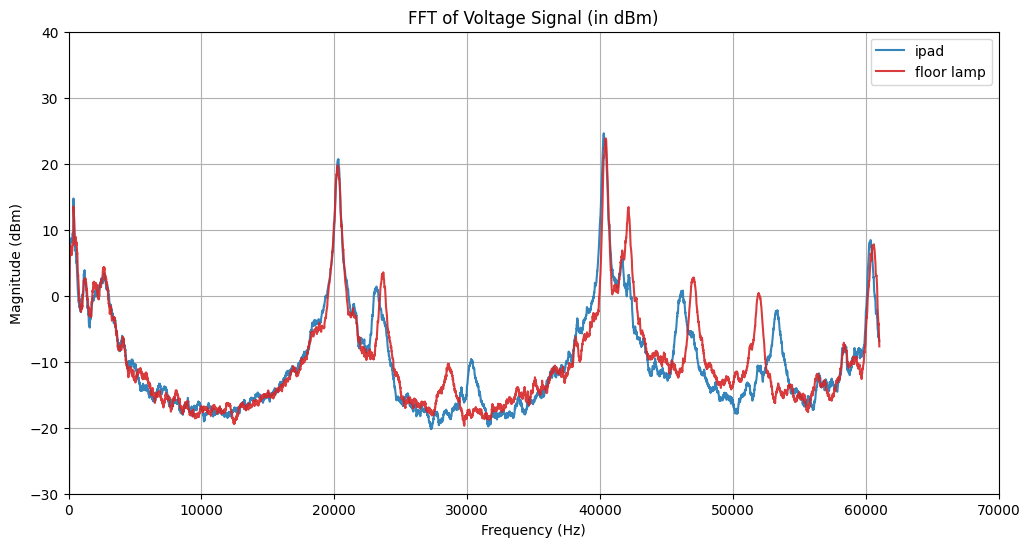

In [39]:
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Function to process FFT and compute dBm values
def process_fft(file_path, sampling_rate, window_size=50):
    # Load the data
    data = pd.read_csv(file_path)
    voltage_signal = data['voltage'].values
    
    # Compute the FFT
    N = len(voltage_signal)
    yf = fft(voltage_signal)
    xf = fftfreq(N, 1 / sampling_rate)
    
    # Extract positive frequencies and magnitudes
    positive_frequencies = xf[:N // 2]
    positive_magnitudes = np.abs(yf[:N // 2])
    
    # Convert magnitude to dBm
    reference_impedance = 50  # Assuming a 50-ohm system
    power_dBm = 10 * np.log10((positive_magnitudes ** 2) / reference_impedance)
    
    # Apply moving average
    power_dBm_smoothed = pd.Series(power_dBm).rolling(window=window_size, min_periods=1).mean()
    
    return positive_frequencies, power_dBm_smoothed

# Define sampling rate
base_sampling_rate = 125000000  # 125 MHz
decimation_factor = 1024
sampling_rate = base_sampling_rate / decimation_factor

# Process both files
file_path1 = 'session_001_CH1.csv'
file_path2 = 'session_002_CH1.csv'
file_path3 = 'session_003_CH1.csv'
file_path4 = 'session_004_CH1.csv'

frequencies1, power_dBm_smoothed1 = process_fft(file_path1, sampling_rate)
frequencies2, power_dBm_smoothed2 = process_fft(file_path2, sampling_rate)
frequencies3, power_dBm_smoothed3 = process_fft(file_path3, sampling_rate)
frequencies4, power_dBm_smoothed4 = process_fft(file_path4, sampling_rate)

# Plot both FFT results
plt.figure(figsize=(12, 6))
plt.plot(frequencies1, power_dBm_smoothed1, label='ipad', alpha=0.9, color='tab:blue' )
# plt.plot(frequencies2, power_dBm_smoothed2, label='ipad', alpha=0.8)
# plt.plot(frequencies3, power_dBm_smoothed3, label='mac', alpha=0.8)
plt.plot(frequencies4, power_dBm_smoothed4, label='floor lamp', alpha=0.9, color='tab:red')
plt.xlim(0, 70000)  # Limit x-axis range
plt.ylim(-30, 40)  # Limit y-axis range
plt.title('FFT of Voltage Signal (in dBm)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dBm)')
plt.grid(True)
plt.legend()
plt.show()


visualization of preprocessing methods

Select processing method:
1. FFT
2. Welch
3. Histogram


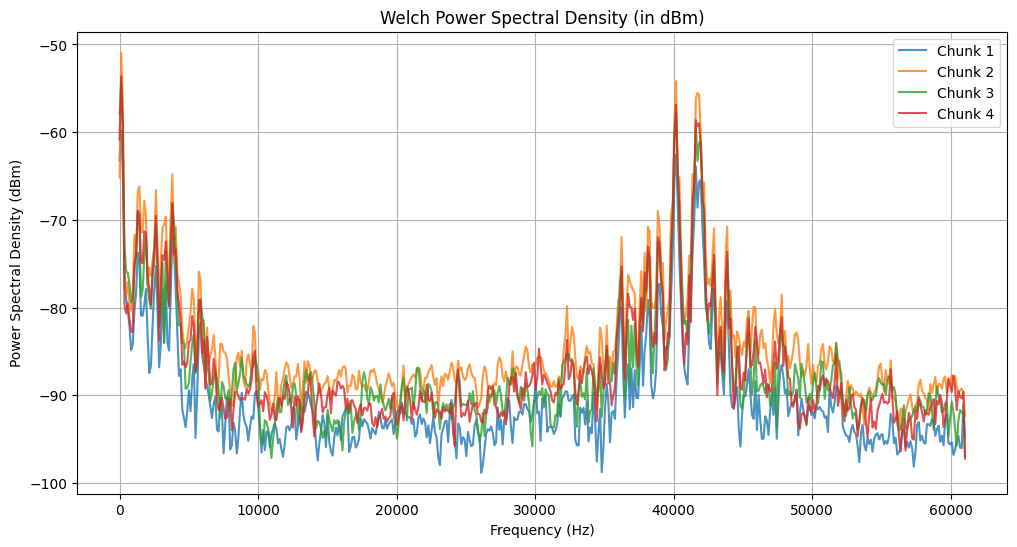

In [2]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt

# Function to process FFT and compute dBm values
def process_fft(signal_chunk, sampling_rate, window_size=50):
    """
    Process FFT for a given signal chunk and compute dBm values.
    
    Parameters:
        signal_chunk (np.ndarray): The voltage signal chunk.
        sampling_rate (float): Sampling rate of the signal.
        window_size (int): Window size for smoothing.
        
    Returns:
        tuple: Frequencies and smoothed power in dBm.
    """
    N = len(signal_chunk)
    yf = fft(signal_chunk)
    xf = fftfreq(N, 1 / sampling_rate)
    
    # Extract positive frequencies and magnitudes
    positive_frequencies = xf[:N // 2]
    positive_magnitudes = np.abs(yf[:N // 2])
    
    # Convert magnitude to dBm
    reference_impedance = 50  # Assuming a 50-ohm system
    power_dBm = 10 * np.log10((positive_magnitudes ** 2) / reference_impedance)
    
    # Apply moving average
    power_dBm_smoothed = pd.Series(power_dBm).rolling(window=window_size, min_periods=1).mean()
    
    return positive_frequencies, power_dBm_smoothed

# Function to process Welch's method and compute dBm values
def process_welch(signal_chunk, sampling_rate):
    """
    Process Welch's method for a given signal chunk and compute dBm values.
    
    Parameters:
        signal_chunk (np.ndarray): The voltage signal chunk.
        sampling_rate (float): Sampling rate of the signal.
        
    Returns:
        tuple: Frequencies and power in dBm.
    """
    frequencies, power_spectrum = welch(signal_chunk, fs=sampling_rate, nperseg=1024)
    # Convert power spectrum to dBm
    reference_impedance = 50  # Assuming a 50-ohm system
    power_dBm = 10 * np.log10(power_spectrum / reference_impedance)
    return frequencies, power_dBm

# Function to compute histogram
def process_histogram(signal_chunk, bins=50):
    """
    Compute histogram of the signal chunk.
    
    Parameters:
        signal_chunk (np.ndarray): The voltage signal chunk.
        bins (int): Number of bins for the histogram.
        
    Returns:
        tuple: Bin centers and histogram counts.
    """
    counts, bin_edges = np.histogram(signal_chunk, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts

# Function to convert binary data to a DataFrame
def binary_to_dataframe(binary_filepath, input_range=1.0, adc_bits=16):
    """
    Convert a binary file containing interleaved CH1 and CH2 data into a DataFrame.

    Parameters:
        binary_filepath (str): Path to the binary file.
        input_range (float): Input range of the ADC (1:1 divider).
        adc_bits (int): Number of ADC bits
        
    Returns:
        pd.DataFrame: DataFrame containing voltage_ch1 and voltage_ch2.
    """
    # Read the binary file
    with open(binary_filepath, 'rb') as f:
        raw_data = f.read()
    
    # Convert to 16-bit integers
    samples = np.frombuffer(raw_data, dtype=np.int16)
    
    # Split interleaved data
    ch1_samples = samples[::2]  # Every other sample for CH1
    ch2_samples = samples[1::2]  # Every other sample for CH2

    # Convert raw ADC values to voltages
    voltage_ch1 = np.array(ch1_samples) * (input_range / (2**(adc_bits - 1)))
    voltage_ch2 = np.array(ch2_samples) * (input_range / (2**(adc_bits - 1)))
    
    # Create a DataFrame
    df = pd.DataFrame({
        'voltage_ch1': voltage_ch1,
        'voltage_ch2': voltage_ch2
    })
    
    return df

# Main script
if __name__ == "__main__":
    # Define sampling rate
    base_sampling_rate = 125000000  # 125 MHz
    decimation_factor = 1024
    sampling_rate = base_sampling_rate / decimation_factor

    # Subset size for processing
    subset_size = 10000

    # Prompt user to select processing method
    print("Select processing method:")
    print("1. FFT")
    print("2. Welch")
    print("3. Histogram")
    choice = input("Enter the number corresponding to your choice: ")

    if choice == '1':
        processing_method = 'fft'
    elif choice == '2':
        processing_method = 'welch'
    elif choice == '3':
        processing_method = 'histogram'
    else:
        print("Invalid choice. Exiting.")
        exit()

    # Process a single session binary file
    file_path = 'session_007.bin'  # Replace with your binary file path
    df = binary_to_dataframe(file_path)

    # Process the data
    signal = df['voltage_ch1'].values  # Using CH1 data

    # Split the signal into chunks
    total_samples = len(signal)
    chunk_count = total_samples // subset_size

    plt.figure(figsize=(12, 6))

    for i in range(chunk_count):
        # Extract the chunk
        signal_chunk = signal[i * subset_size:(i + 1) * subset_size]

        if processing_method == 'fft':
            # Compute FFT
            frequencies, power_dBm_smoothed = process_fft(signal_chunk, sampling_rate)
            # Plot results
            if i < 4:  # Limit to first few chunks for clarity
                plt.plot(
                    frequencies,
                    power_dBm_smoothed,
                    label=f"Chunk {i + 1}",
                    alpha=0.8
                )
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude (dBm)')
            plt.title('FFT of Voltage Signal (in dBm)')

        elif processing_method == 'welch':
            # Compute Welch
            frequencies, power_dBm = process_welch(signal_chunk, sampling_rate)
            # Plot results
            if i < 4:
                plt.plot(
                    frequencies,
                    power_dBm,
                    label=f"Chunk {i + 1}",
                    alpha=0.8
                )
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power Spectral Density (dBm)')
            plt.title('Welch Power Spectral Density (in dBm)')

        elif processing_method == 'histogram':
            # Compute histogram
            bin_centers, counts = process_histogram(signal_chunk)
            # Plot results
            if i < 4:
                plt.plot(
                    bin_centers,
                    counts,
                    label=f"Chunk {i + 1}",
                    alpha=0.8
                )
            plt.xlabel('Voltage (V)')
            plt.ylabel('Probability Density')
            plt.title('Histogram of Voltage Signal')

    # Configure plot
    plt.grid(True)
    plt.legend()
    plt.show()
